In [4]:
import os
from dotenv import load_dotenv

platform_domain = "https://staging.eodatahub.org.uk"
workspace = "sgillies-tpzuk"
load_dotenv(".env")
token = os.environ["API_TOKEN"]
workspaces_bucket = "workspaces-eodhp-staging"

## Resource Catalogue

### Searching the entire catalogue

In [38]:
!pip install pystac-client
!pip install matplotlib
!pip install pillow


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 9.0 MB/s eta 0:00:009.4 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.6 MB/s eta 0:00:004.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (4.5 MB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade

In [6]:
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"{platform_domain}/api/catalogue/stac"

# We can also view the STAC Catalogue using STAC Browser here 
# https://staging.eodatahub.org.uk/static-apps/stac-browser/main/index.html#/external/staging.eodatahub.org.uk/api/catalogue/stac/

# Create STAC client
stac_client = Client.open(rc_url)

In [7]:
# See all the available children in this catalogue
children = stac_client.get_children()

for child in children:
    print(child.id)

supported-datasets
user-datasets


In [8]:
# See all collections available (recursive searching)
collections = stac_client.get_collections()

for collection in collections:
    for link in collection.links:
        if link.rel == "self":
            print(f"Collection {collection.id} can be found at {link.href}")

Collection ukcp can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/ukcp
Collection sentinel2_ard can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel2_ard
Collection sentinel1 can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/sentinel1
Collection land_cover can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/land_cover
Collection eocis-sst-cdrv3-climatology can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/ceda-stac-catalogue/collections/eocis-sst-cdrv3-climatology
Collection eocis-sst-cdrv3 can be found at https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/c

In [9]:
# Do some collection searching using keywords
collection_search = stac_client.collection_search(
    q="climate",
)
print(f"{collection_search.matched()} collections found")
for collection in collection_search.collections():
    print(collection.id)

AttributeError: 'Client' object has no attribute 'collection_search'

In [10]:
# Do some collection searching using bbox
uk_bbox = [10.854492,49.823809,100.762709,60.860699]
collection_search = stac_client.collection_search(
    bbox=uk_bbox,
)
print(f"{collection_search.matched()} collections found")
for collection in collection_search.collections():
    print(collection.id)

AttributeError: 'Client' object has no attribute 'collection_search'

In [11]:
# Do some collection searching using datetime, looking into the future
time_to_search = "2026-01-06T00:00:00Z/.."
collection_search = stac_client.collection_search(
    datetime=time_to_search,
)
print(f"{collection_search.matched()} collections found")
for collection in collection_search.collections():
    print(collection.id)

AttributeError: 'Client' object has no attribute 'collection_search'

In [12]:
# We can then get all the items in the cmip6 collection
print(collection.id)
items = collection.get_items()
print(next(collection.get_items(), None))

PSScene


APIError: Internal Server Error

In [ ]:
# Do some item searching
# Geometry for the UK
geom = {
    "type": "Polygon",
    "coordinates": [
        [
            [-4.41191386337143, 50.5437323318846],
            [-2.86223024423239, 50.5522106222613],
            [-2.86502949737798, 49.564676297854],
            [-4.3832372671439, 49.5564878434316],
            [-4.41191386337143, 50.5437323318846]
        ]
    ],
}
search = stac_client.search(
    max_items=10,
    collections=['cmip6'],
    intersects=geom,
)
for item in search.items():
    print(item.id)

In [13]:
# We can then see the assets for one of these items
assets = item.get_assets()

for asset in assets:
    print(f"Asset {asset} is available at {assets[asset].href}")

NameError: name 'item' is not defined

In [14]:
# Demonstrate that we support more complex searching via filters extension
filter = {
        "op": "and",
        "args": [
          {
            "op": "between",
            "args": [
              {
                "property": "properties.datetime"
              },
              "2020-01-12T00:00:00.000Z",
              "2025-02-12T23:59:59.999Z"
            ]
          },
          {
            "op": "and",
            "args": [
              {
                "op": "=",
                "args": [
                  {
                    "property": "collection"
                  },
                  "sentinel2_ard"
                ]
              },
              {
                "op": "<=",
                "args": [
                  {
                    "property": "properties.eo:cloud_cover"
                  },
                  5
                ]
              }
            ]
          }
        ]
      }
    
search = stac_client.search(
    max_items=10,
    filter=filter,
    fields={"include": ["properties.datetime", "properties.eo:cloud_cover"]},
)

for item in search.items():
    print(item.id)
    print(f"Datetime is {item.properties['datetime']}")
    print(f"Cloud cover is {item.properties['eo:cloud_cover']}")

# To then use such an item in a workflow, you can retrieve the href
for link in item.links:
    if link.rel == "self":
        print(f"Self href for item {item.id} is {link.href}")

neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn554lonw0021_T30UWG_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 0.0
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn546lonw0022_T30UWF_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 0.303176949448
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn537lonw0022_T30UWE_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 2.996021415101
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn536lonw0007_T30UXE_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 0.321000925677
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn528lonw0022_T30UWD_ORB137_20231117131218_utm30n_osgb
Datetime is 2023-11-17T11:13:31Z
Cloud cover is 3.548329970558
neodc.sentinel_ard.data.sentinel_2.2023.11.17.S2A_20231117_latn527lonw0007_T30UXD_ORB137_20231117131218_utm30n_osgb


### Our deployment also supports nested catalogs, which we can return by listing the children for a specific catalog

In [15]:
# Return children for a given nested catalog
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"{platform_domain}/api/catalogue/stac/catalogs/supported-datasets"

# We can also view the STAC Catalogue using STAC Browser here 
# https://staging.eodatahub.org.uk/static-apps/stac-browser/main/index.html#/external/staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets

# Create STAC client
stac_client = Client.open(rc_url)

In [16]:
# See all the available children in this catalogue
children = stac_client.get_children()

for child in children:
    print(child.id)
    # We will also print the first three collections in each
    print(next(child.get_children()).id)

airbus
airbus_phr_data
ceda-stac-catalogue
cci
earth-search-aws
cop-dem-glo-30
planet
PSScene


In [17]:
# Then we can see the child collections for one of these catalogs
# See all the available children in this catalogue
children = stac_client.get_children()

for child in children:
    if child.id == "ceda-stac-catalogue":
        ceda_catalog = child
        break

collections = ceda_catalog.get_children()

for collection in collections:
    print(collection.id)

cci
cmip6
cordex
eocis-aerosol-slstr-daily-s3a
eocis-aerosol-slstr-daily-s3b
eocis-aerosol-slstr-monthly-s3a
eocis-aerosol-slstr-monthly-s3b
eocis-lst-day
eocis-lst-s3a-day
eocis-lst-s3a-night
eocis-lst-s3b-day
eocis-lst-s3b-night
eocis-sst-cdrv3
eocis-sst-cdrv3-climatology
land_cover
sentinel1
sentinel2_ard
ukcp


### We can also access private catalogs by providing credentials to the client

In [18]:
# Return children for a given nested catalog
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"{platform_domain}/api/catalogue/stac/catalogs/user-datasets"

# We can also view the STAC Catalogue using STAC Browser here 
# https://staging.eodatahub.org.uk/static-apps/stac-browser/main/index.html#/external/staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user-datasets

# Create STAC client without authentication
stac_client = Client.open(rc_url)

In [19]:
# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see that no child catalogs are provided, as auth is required for user catalogs

for child in children:
    print(child.id)


In [20]:
# And now with authentication
# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})

# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see the child catalogs

for child in children:
    print(child.id)

tjellicoe-tpzuk
workflowtestuser


In [21]:
# Navigate to workflow output sub catalog
# And now with authentication
# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})
# See all the available children in this catalogue
children = stac_client.get_children()
# We can then see the child catalogs
for child in children:
    if child.id == workspace:
        priv_cat = child
        break
priv_cat_children = priv_cat.get_children()
for cat in priv_cat_children:
    if cat.id == "processing-results":
        proc_res_cat = cat
for workflow_cat in proc_res_cat.get_children():
    if workflow_cat.id == "convert-url-test":
        for job in workflow_cat.get_children():
            print(job.id)

cat_3f4db7ca-ed08-11ef-b95b-ca3e8cd28499
cat_f520c3fc-e953-11ef-a139-ca3e8cd28499


In [22]:
# Print output collection from workflow
print(job.id)
collections = job.get_collections()

collection = next(collections)
items = collection.get_items()

for item in items:
    print(item.id)

cat_f520c3fc-e953-11ef-a139-ca3e8cd28499
EO-Data-Hub-logo_colour_425px-resize-1739373255.101168063


### We also include a proxy for searching the Planet API

In [24]:
# Return children for a given nested catalog
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"{platform_domain}/api/catalogue/stac/catalogs/supported-datasets/catalogs/planet"

# Create STAC client without authentication
stac_client = Client.open(rc_url)

In [25]:
# Now search for some items
collections = stac_client.get_children()

for collection in collections:
    print(collection.id)

PSScene
REOrthoTile
REScene
SkySatCollect
SkySatScene
SkySatVideo
TanagerMethane
TanagerScene


In [26]:
# The proxy also works when searching Planet items
search = stac_client.search(bbox=[10.854492,49.823809,100.762709,60.860699])
for i in range(10):
    print(next(search.items()).id)

20250219_061247_40_24c4
20250219_085826_11_24c5
20250219_090532_31_24c5
20250219_134714_28_250b
20250219_103913_96_24c6
20250219_134410_47_250b
20250219_102809_33_24c6
20250219_062407_92_24fa
20250219_103913_96_24c6
20250219_134706_11_250b


# Data Adaptors

## Airbus Adaptors

First we will follow the path of a user discovering data they may wish to order

In [33]:
## The user will search the resource catalogue for Airbus data they wish to order
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"{platform_domain}/api/catalogue/stac"

# Create STAC client without authentication
stac_client = Client.open(rc_url)

# Search for airbus data that meets certain criteria
search = stac_client.search(collections=["airbus_sar_data"], bbox=[10.854492,49.823809,100.762709,60.860699], max_items=10)

# View all the items returned
for item in search.items():
    print(item.id)

chosen_item = item

TSX-1_WS_S_wide_001R_97985_D33003943_29000
TSX-1_ST_S_spot_060R_97984_D32148211_435
TSX-1_SM_S_strip_014R_98015_D32043560_7992
TSX-1_SM_S_strip_006R_98008_A14244245_8000
TSX-1_SL_S_spot_067R_97983_D32248267_1422
TDX-1_SM_D_stripFar_007R_81247_A15134647_13718
TSX-1_WS_S_wide_004R_97909_D33004053_29000
TSX-1_SM_S_strip_014R_97952_D31979581_8000
TSX-1_SM_S_strip_014R_97901_A14191034_8000
TSX-1_SM_S_strip_013R_97955_D32195536_8000


In [41]:
# with the user's chosen item then can extract the link for this item in preparation to order its associated data
item_links = chosen_item.links

for link in item_links:
    if link.rel == "self":
        item_href = link.href
        print(item_href)

https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/airbus/collections/airbus_sar_data/items/TSX-1_SM_S_strip_013R_97955_D32195536_8000


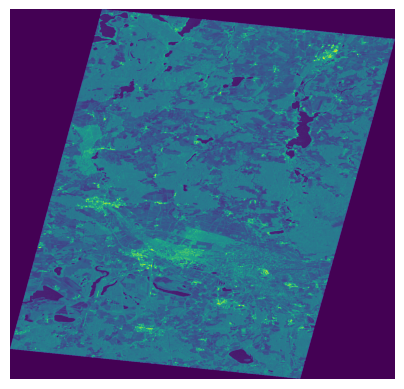

In [49]:
# A user may also wish to view any thumbnail images to confirm this is the data they wish to order
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Find the thumbnail asset
thumbnail_href = chosen_item.assets["thumbnail"].href

# URL of the TIFF image
url = thumbnail_href

# Fetch the image from the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


### Now we are happy with the data we are ordering we can construct an order call with the adapters API

In [50]:
import requests

url = f"{platform_domain}/api/catalogue/manage/catalogs/user-datasets/{workspace}/commercial-data"
headers = {
    "accept": "application/json", 
    "Content-Type": "application/json", 
    "Authorization": f"Bearer {token}"
}
data =  {
    "url": item_href,  
    "product_bundle": "general_use"
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/airbus/collections/airbus_sar_data/items/TSX-1_SM_S_strip_013R_97955_D32195536_8000
Status Code 200


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Planet Adaptor

First we need to identify the data we wish to order

In [66]:
## The user will search the resource catalogue for Airbus data they wish to order
from pystac_client import Client

# Set resource catalogue top-level url
rc_url = f"{platform_domain}/api/catalogue/stac/catalogs/supported-datasets/catalogs/planet"

# Create STAC client without authentication
stac_client = Client.open(rc_url)

# Search for airbus data that meets certain criteria
search = stac_client.search(collections=["PSScene"], bbox=[9.0, 56.9, 9.9, 57.11], max_items=10)

# View all the items returned
for item in search.items():
    print(item.id)

chosen_item = item

20250219_074140_32_24db
20250219_074912_99_24db
20250219_074951_45_24db
20250219_075542_10_24db
20250219_074657_26_24db
20250219_090326_90_24bd
20250219_075202_66_24db
20250219_075144_56_24db
20250219_074448_31_24db
20250219_075048_01_24db


In [67]:
# with the user's chosen item then can extract the link for this item in preparation to order its associated data
item_links = chosen_item.links

for link in item_links:
    if link.rel == "self":
        item_href = link.href
        print(item_href)

https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/supported-datasets/catalogs/planet/collections/PSScene/items/20250219_075048_01_24db


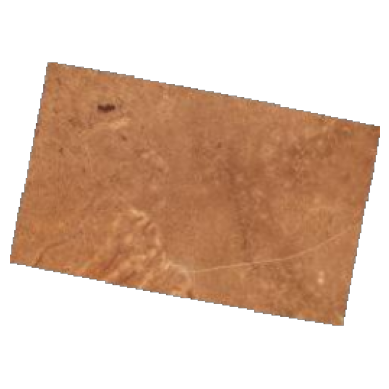

In [68]:
# A user may also wish to view any thumbnail images to confirm this is the data they wish to order
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Find the thumbnail asset
thumbnail_href = chosen_item.assets["thumbnail"].href

# URL of the TIFF image
url = thumbnail_href

# Fetch the image from the URL
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [69]:
import requests

url = f'{platform_domain}/api/catalogue/manage/catalogs/user-datasets/{workspace}/commercial-data'
headers = {
    'accept': 'application/json', 
    'Content-Type': 'application/json', 
    'Authorization': f'Bearer {token}'
}
data =  {
    "url": item_href,  
    "product_bundle": "analytic_udm2", 
    "coordinates": [
        [
            [9.6, 57.1],
            [9.6, 57.0],
            [9.8, 56.9],
            [9.8, 57.0],
            [9.6, 57.1]
        ]
    ]
}

response = requests.post(url, headers=headers, json=data)

print("Status Code", response.status_code)
print("Response ", response.json())

print(f"{platform_domain}/api/catalogue/stac/catalogs/user-datasets/catalogs/{workspace}/catalogs/commercial-data/catalogs/planet/catalogs")

Status Code 200
Response  {'message': 'Item ordered successfully'}
https://staging.eodatahub.org.uk/api/catalogue/stac/catalogs/user-datasets/catalogs/workflowtestuser/catalogs/commercial-data/catalogs/planet/catalogs


## Checking Adapter Outputs

In [72]:
# Now that we have submitted two data requests, one for Airbus and another for Planet, 
# we can view them in the resource catalogue, once delivered

# We first need to create a pystac client instance with authentication
rc_url = f"{platform_domain}/api/catalogue/stac/catalogs/user-datasets/catalogs/workflowtestuser"

# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})

# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see the child catalogs

for child in children:
    print(child.id)
    if child.id == "commercial-data":
        commercial_cat = child

commercial-data
processing-results
saved-data


In [77]:
# Adapter outputs are placed in the commercial-data sub-catalog
children = commercial_cat.get_children()

for c in children:
    print(c.id)
    if c.id == "planet":
        planet_cat = c
    if c.id == "airbus":
        airbus_cat = c

planet


In [82]:
## Now we can view all the outputs for the planet adaptor
outputs = planet_cat.get_children()

for o in outputs:
    print(o.id)

cat_31e1488e-eed6-11ef-9ce3-ca3e8cd28499


In [90]:
## And then any collections and items
collections = o.get_collections()

for col in collections:
    items = col.get_items()
    for i in items:
        print(f"Found item {i.id} in collection {col.id}")
        # We can also print the order status
        print(f"Order status is {i.properties['order.status']}")

Found item 20250219_075048_01_24db in collection col_31e1488e-eed6-11ef-9ce3-ca3e8cd28499
Order status is failed


In [91]:
## Now we can view all the outputs for the airbus adaptor
outputs = airbus_cat.get_children()

for o in outputs:
    print(o.id)

NameError: name 'airbus_cat' is not defined

In [92]:
## And then any collections and items
collections = o.get_collections()

for col in collections:
    items = col.get_items()
    for i in items:
        print(f"Found item {i.id} in collection {col.id}")
        # We can also print the order status
        print(f"Order status is {i.properties['order.status']}")

Found item 20250219_075048_01_24db in collection col_31e1488e-eed6-11ef-9ce3-ca3e8cd28499
Order status is failed


## Running Workflows with pyeodh

In [3]:
!pip install pyeodh


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os

import dotenv
import json

import pyeodh

dotenv.load_dotenv()

client = pyeodh.Client(
    username=workspace,
    token=token,
)
ades = client.get_ades()

ModuleNotFoundError: No module named 'pyeodh'

In [94]:
# Define a CWL application package
workflow_id = "convert-url"
cwl_yaml = f"""cwlVersion: v1.0
$namespaces:
  s: https://schema.org/
s:softwareVersion: 0.1.2
schemas:
  - http://schema.org/version/9.0/schemaorg-current-http.rdf
$graph:
  # Workflow entrypoint
  - class: Workflow
    id: {workflow_id}
    label: convert url app
    doc: Convert URL
    requirements:
      ResourceRequirement:
        coresMax: 1
        ramMax: 1024
    inputs:
      fn:
        label: the operation to perform
        doc: the operation to perform
        type: string
        default: "resize"
      url:
        label: the image to convert
        doc: the image to convert
        type: string
      size:
        label: the percentage for a resize operation
        doc: the percentage for a resize operation
        type: string
    outputs:
      - id: converted_image
        type: Directory
        outputSource:
          - convert/results
    steps:
      convert:
        run: "#convert"
        in:
          fn: fn
          url: url
          size: size
        out:
          - results
  # convert.sh - takes input args `--url`
  - class: CommandLineTool
    id: convert
    requirements:
      ResourceRequirement:
        coresMax: 1
        ramMax: 512
    hints:
      DockerRequirement:
        dockerPull: public.ecr.aws/n1b3o1k2/ades-workflow-examples:working
    baseCommand: convert.sh
    inputs:
      fn:
        type: string
        inputBinding:
          position: 1
      url:
        type: string
        inputBinding:
          position: 2
          prefix: --url
      size:
        type: string
        inputBinding:
          position: 3
    outputs:
      results:
        type: Directory
        outputBinding:
          glob: .
"""

In [ ]:
# Now deploy an application package
try:
    ades.get_process("convert-url").delete()
except Exception:
    print("Process not found, undeploy not required.")

process = ades.deploy_process(cwl_yaml=cwl_yaml)

In [ ]:
# Now execute the workflow
job = ades.get_process("convert-url").execute(
    {
        "url": "https://raw.githubusercontent.com/EO-DataHub/test-workflow-store/main/EO-Data-Hub-logo_colour_425px.png",
        "fn": "resize",
        "size": "50%",
    }
)
# Print the job href
print(job.self_href)

In [ ]:
# Monitor the job for completion
print(job.refresh())
print(job.status)
print(job.id)

job_id = job.id

catalog_href = f"https://test.eodatahub.org.uk/api/catalogue/stac/catalogs/user-datasets/{workspace}/processing-results/cat_{job_id}"

## We can now view the job outputs in the workspace catalogue

In [6]:
# Now that we have submitted two data requests, one for Airbus and another for Planet, 
# we can view them in the resource catalogue, once delivered

# We first need to create a pystac client instance with authentication
rc_url = f"{platform_domain}/api/catalogue/stac/catalogs/user-datasets/catalogs/workflowtestuser/catalogs/processing-results"

# Create STAC client
stac_client = Client.open(rc_url, headers={"Authorization": f"Bearer {token}"})

# See all the available children in this catalogue
children = stac_client.get_children()

# We can then see the child catalogs, which represent workflow output catalogs
for child in children:
    print(child.id)
    if child.id == "convert-url":
        commercial_cat = child

NameError: name 'platform_domain' is not defined

## EO Packages

Users can install EO data packages to view their data

In [70]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib numpy pillow folium

import os

import shapely 
import geopandas as gpd
import folium

import urllib.request
from io import BytesIO 
from PIL import Image

rut_pnt = shapely.Point(-0.683261054299237, 52.672193937442586) # a site near Rutland
thet_pnt = shapely.Point(0.6715892933273722, 52.414471075812315) # a site near Thetford

# Optional cell
# If you want to see these points on a map run this cell

# Create a map (m) centered between the two points
center_lat = (rut_pnt.y + thet_pnt.y) / 2
center_lon = (rut_pnt.x + thet_pnt.x) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=8)

# Add markers for each point
folium.Marker([rut_pnt.y, rut_pnt.x], popup="Rutland Site", icon=folium.Icon(color="blue")).add_to(m)
folium.Marker([thet_pnt.y, thet_pnt.x], popup="Thetford Site", icon=folium.Icon(color="green")).add_to(m)

# Step 4: Display the map
m

ModuleNotFoundError: No module named 'folium'

## PyEODH

A user can use Oxidian's PyEODH client to work with the UK EO DataHub's API.

In [5]:
import pyeodh

# Connect to the Hub
client = pyeodh.Client().get_catalog_service()

# Print a list of the collections held in the Resource Catalogue (their id and description).
# As the Resource Catalogue fills and development continues, the number of collections and the richness of their descriptions will increase
for collect in client.get_collections():
    print(f"{collect.id}: {collect.description}")

ukcp: Regional climate model projections produced as part of the UK Climate Projection 2018 (UKCP18) project. The data produced by the Met Office Hadley Centre provides information on changes in climate for the UK until 2080, downscaled to a high resolution (12km), helping to inform adaptation to a changing climate. The projections cover Europe and a 100 year period, 1981-2080, for a high emissions scenario, RCP8.5. Each projection provides an example of climate variability in a changing climate, which is consistent across climate variables at different times and spatial locations. This dataset contains 12km data for the United Kingdom, the Isle of Man and the Channel Islands provided on the Ordnance Survey's British National Grid.
sentinel2_ard: These data have been created by the Department for Environment, Food and Rural Affairs (Defra) and Joint Nature Conservation Committee (JNCC) in order to cost-effectively provide high quality, Analysis Ready Data (ARD) for a wide range of appl